# Pryngles module: Plotting

In [3]:
from pryngles import *

## External modules

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math

#Plotting in 3d
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation

## The Plot Utilities

In [11]:
class Plot(object):
    
    def pathpatch_2d_to_3d(pathpatch,pivot=[0,0,0],zDir=[0,0,1]):
        """
        Create a patch in 3d around pivot in the direction of zDir
        
        Source: https://stackoverflow.com/a/69785236
        """

        path = pathpatch.get_path() #Get the path and the associated transform
        trans = pathpatch.get_patch_transform()
        path = trans.transform_path(path) #Apply the transform

        pathpatch.__class__ =  mplot3d.art3d.PathPatch3D #Change the class
        pathpatch._path2d = path       #Copy the 2d path
        pathpatch._code3d = path.codes #Copy the codes
        pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color

        # Get the 2D vertices and add the third dimension
        verts3d = np.empty((path.vertices.shape[0],3))
        verts3d[:,0:2] = path.vertices
        verts3d[:,2] = pivot[2]

        #Get rotation matriz
        norm = np.linalg.norm(zDir)
        zDir = zDir/norm
        if np.abs(zDir[2])==1:
            yDir = np.array([0,zDir[2],0])
        else:
            yDir = (np.array([0,0,1]) - zDir[2]*zDir)/math.sqrt(1-zDir[2]**2)
        rotMat = np.empty((3,3))
        rotMat[:,0] = np.cross(zDir,yDir)
        rotMat[:,1] = yDir
        rotMat[:,2] = -zDir
        R=Rotation.from_matrix(rotMat)

        #Displace
        pathpatch._segment3d = R.apply(verts3d - pivot) + pivot

        return pathpatch

    # places a 3D circle in axes with 3d projection. 
    def circle3d(ax, center = (0,0,0), radius = 1, zDir='z', **kwargs):
        """
        Add a circle in 3d
        """
        pc = Circle(center[0:2], radius, **kwargs)
        ax.add_patch(Plot.pathpatch_2d_to_3d(pc, center, zDir))
        
    def pryngles_mark(ax):
        #Height of axe
        axh=ax.get_window_extent().transformed(ax.get_figure().dpi_scale_trans.inverted()).height
        fig_factor=axh/4
        
        args=dict(
            rotation=270,ha='left',va='top',
            transform=ax.transAxes,color='pink',fontsize=8*fig_factor,zorder=100
        )
        mark=f"Pryngles {version}"
        try:
            ax.add_collection3d
            plt_text=ax.text2D
        except:
            plt_text=ax.text
            
        text=plt_text(1,1,mark,**args);
        return text

## Testing

<IPython.core.display.Javascript object>


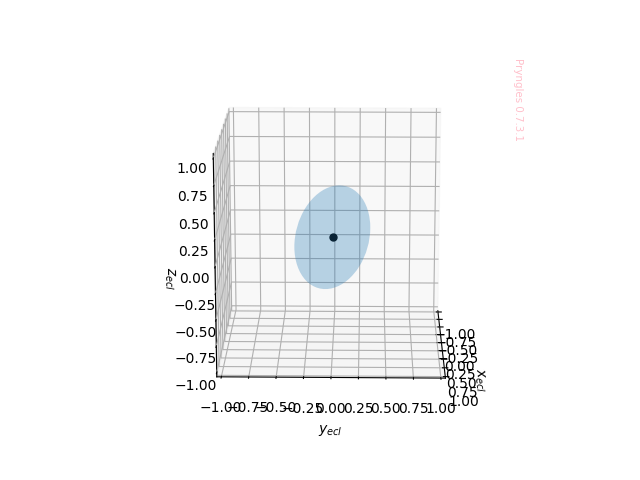

.

3.696



----------------------------------------------------------------------
Ran 1 test in 0.022s

OK


In [12]:
if IN_JUPYTER:
    def test_fun(self):
        fig=plt.figure()
        ax=fig.add_subplot(111,projection='3d')
        ax.plot([0],[0],[0],'ko',markersize=5)
        Plot.circle3d(ax,(0,0,0),0.5,zDir=[1,1,0],fill='None',alpha=0.3)
        #Decoration
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.set_zlim(-1,1)
        ax.set_box_aspect([1,1,1])
        ax.set_xlabel("$x_{ecl}$")
        ax.set_ylabel("$y_{ecl}$")
        ax.set_zlabel("$z_{ecl}$")
        ax.view_init(elev=15,azim=1)
        Plot.pryngles_mark(ax)
        
    class Test(unittest.TestCase):pass
    Test.test_fun=test_fun
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--